In [14]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating project at `~/Documents/eth_courses/notebooks/dynamics/julia/demos/quad_2d`


In [1]:
using ModelingToolkit, LinearAlgebra
using GLMakie
using ControlSystems
using DifferentialEquations
using ForwardDiff

include("utilities.jl")
include("types.jl")

LoadError: ArgumentError: Package ForwardDiff not found in current path.
- Run `import Pkg; Pkg.add("ForwardDiff")` to install the ForwardDiff package.

## Utilities 

In [2]:
# # 2D rotation matrix
# R_2D(θ::Float64) = [cos(θ) -sin(θ); sin(θ) cos(θ)];

In [166]:
motor_left = BLDCMotor(0, 12.5)
motor_right = BLDCMotor(0, 12.5)

quad_obj = Quad2d(1.0, 0.1, 0.003, motor_left, motor_right)
sim_params = SimParams(6,2,3, 0.01) 
safety_box = SafetyBox(x_min=-10, x_max=10, y_min=-10, y_max=10, z_min=0, z_max=20);

In [167]:
struct SafetyBox3
    x_max::Float64
    y_max::Float64
    z_max::Float64

    x_min::Float64
    y_min::Float64
    z_min::Float64

    function SafetyBox3(;x_max=x_max,y_max=y_max,z_max=z_max,x_min=x_min,y_min=y_min,z_min=z_min)
        new(x_max,y_max,z_max,x_min,y_min,z_min)
    end
    
end
SafetyBox = SafetyBox3


SafetyBox3

## Dynamics using ModellingToolkit

## Plant

In [155]:
function Plant(;name, l, I_xx, m)
    
    # define parameters and variables
    
    params = @parameters l=l I_xx=I_xx m=m
    
    # state variables
    @variables t (X(t))[1:6, 1:1]=0 (Y(t))[1:6]=0 
    
    # control input
    @variables (U(t))[1:2]=0 [input=true]
    
    @constants g=9.81 
    
    # define operators
    D = Differential(t)

    f_1 = U[1]
    f_2 = U[2]

    f_thrust = f_1 + f_2
    a_thrust = (f_thrust / m) # mass normalized thrust 
    
    τ = (f_1 - f_2) * l
    
    # dynamics equations
    
    # gravity 
    g_vec = [0;g]
    
    # create custom rotation matrix
    R_2D(θ::Real) = [cos(θ) -sin(θ); sin(θ) cos(θ)];

    y = X[1]
    z = X[2]
    θ = X[3]
    ẏ = X[4]
    ż = X[5]
    θ̇ = X[6]
    
    # translation E.O.M
    a = [0; a_thrust]
    (ÿ, z̈) = R_2D(θ)*a - g_vec 

    # rotational E.O.M
    θ̈ = τ / I_xx

    X_dot = [ẏ; ż; θ̇; ÿ; z̈; θ̈]

    eqn1 = D.(X) .~ X_dot

    eqn2 = Y .~ X

    eqs = vcat(eqn1, eqn2)
    
    ODESystem(eqs, t; name)
end

Plant (generic function with 1 method)

In [156]:
# Plant(;name=:quad_2d, l=0.1, I_xx=0.003, m=1.0)

## Controller

### Zero order hold for digital controller

In [132]:
# force control input to be constant over sampling time, actual control law applied inside callback
function Controller_Zero_Order_Hold(;name)
    sts = @variables t U(t)[1:2]=0  (R(t))[1:3]=0

    # define operators
    D = Differential(t)

    eqn1 = D.(U) .~ 0 
    eqn2 = D.(R) .~ 0 

    eqns = vcat(eqn1, eqn2)
    
    ODESystem(eqns, t; name)
end

Controller_Zero_Order_Hold (generic function with 1 method)

## Digital controller

In [128]:
# function pd_controller(e, e_dot; params)
#     # parameters
#     kp, kd = controller_params.kp, controller_params.kd

#     # compute the control action 
#     u = kp * e +  kd * e_dot

#     return u
# end

In [129]:
mutable struct PID2
    kp::Float64 # proportional gain
    ki::Float64 # integral gain
    kd::Float64 # derivative gain

    k_aw::Float64 # integral antiwindup gain

    Ts::Float64 # sampling time
    
    error_integral::Float64 # integral accumulated over time
    prev_error::Float64 # error from prvious time step

    function PID2(;kp=kp, ki=ki, kd=kd, k_aw=k_aw, Ts=Ts)
        new( kp, ki, kd, k_aw, Ts, 0., 0.)
    end
    
end

PID = PID2

function pid_controller(pid::PID; e, umin, umax )
    # parameters
    kp, ki, kd = pid.kp, pid.ki, pid.kd
    h, k_aw = pid.Ts, pid.k_aw

    # compute error terms
    e_dot = (e - pid.prev_error) / h
    
    e_integral = pid.error_integral
    
    # compute the control action 
    u = kp * e +  kd * e_dot +  ki * e_integral

    # limit output to actuator limits 
    u_sat = clamp(u, umin, umax )

    # update integral state 
    pid.error_integral += e*h + k_aw*(u_sat - u)

    # update derivative state 
    pid.prev_error = e

    return u_sat
end

pid_controller (generic function with 1 method)

In [558]:
state_indices = Dict(
    :control=>indexof(controller.U[1], states(sys)),
    :reference=>indexof(controller.R[1], states(sys))
)

allocation_matrix = inv([1 1; 0.1 -0.1])

callback_params = (;state_indices=state_indices, allocation_matrix=allocation_matrix, reference_generator=reference_generator, safety_box=safety_box)


function digital_controller(int; params = callback_params)

    m = 1.0
    g = 9.81
    
    state_indices = params.state_indices
    allocation_matrix = params.allocation_matrix 
    safety_box = params.safety_box

    ## find index of variable controller.u in the state vector
    # controller_index = indexof(controller.u, states(sys))
    # r_index = indexof(controller.r[1], states(sys))

    c_index = state_indices[:control]
    r_index = state_indices[:reference]

    # get plant output
    Y = @view int.u[1:6]

    y = Y[1]
    z = Y[2]
    θ = Y[3]
    ẏ = Y[4]
    ż = Y[5]
    θ̇ = Y[6]

    # Limit operating space 
    if z > safety_box.z_max
        println("Z operational space constraint violated !")
        terminate!(int)

    elseif z < safety_box.z_min
        println("Landed !")
        terminate!(int)
    end

    if y < safety_box.y_min || y > safety_box.y_max
        println("Y operational space constraint violated !")
        terminate!(int)
    end

    # get reference 
    R = reference_generator(int.t)
    # R_dot = ForwardDiff.derivative(reference_generator, int.t)
    # R_ddot = ForwardDiff.derivative(x -> ForwardDiff.derivative(reference_generator, x), int.t)

    e_y = R[1] - y
    e_z = R[2] - z

    # control laws 

    # z position controller
    f_net = m*(g + pid_controller(z_pos_pid; e=e_z, umin=-100, umax=100 ))

    # y position controller
    R[3] = - pid_controller(y_pos_pid; e=e_y, umin=-100, umax=100 ) / g

    # attitude controller
    e_θ = R[3] - θ
    τ = pid_controller(attitude_pid; e=e_θ, umin=-25, umax=25 )

    (f_1, f_2) = allocation_matrix * [f_net,τ] 
    
    # # @show e_y, e_z, e_θ
    # # @show R
    # # @show f_net, τ
    # # println("")

    # set the control input
    int.u[c_index:c_index+1] = [f_1, f_2]
    int.u[r_index: r_index+2] = [R[1], R[2], R[3]]
end

digital_controller (generic function with 1 method)

In [453]:
# indexof(controller.R[1], states(sys))
# states(sys)


## Reference generator

In [497]:
function reference_generator(t)

    r = 0.5    # circle radius 
    ω = 0.2    # angular velocity

    z_0 = 1

    # circular trajectory 
    y_ref = r*sin(ω*t)
    z_ref = z_0 + r*cos(ω*t)

    # y_ref = 1.0
    # z_ref = 2.0
    
    # computed by the controller
    θ_ref = 0.0
    
    return [y_ref, z_ref, θ_ref]
end

reference_generator (generic function with 1 method)

## System building

In [528]:
@named plant = Plant(;name=:quad_2d, l=0.1, I_xx=0.003, m=1.0)
@named controller = Controller_Zero_Order_Hold()

eqn1 = plant.U .~ controller.U

eqns = vcat(eqn1)

# connect the subsystems
@named model = ODESystem(eqns,
    systems=[plant, controller])

sys = structural_simplify(model)

indexof(sym,syms) = findfirst(isequal(sym),syms)

indexof (generic function with 1 method)

## Simulation

In [563]:
# sim
tspan = (0.0, 60.0)

# initial conditions
X₀ = collect(plant.X.=> [0.0, 1.0, 0.0,0.0,0.0,0.0])

# controller
y_pos_pid =  PID(;kp=3.5, ki=0.00, kd=7, k_aw=0.0, Ts=0.01)
z_pos_pid =  PID(;kp=2., ki=0.00, kd=2.5, k_aw=0.0, Ts=0.01)

attitude_pid =  PID(;kp=0.05, ki=0.00, kd=0.07, k_aw=0.0, Ts=0.01)

control_callback = PeriodicCallback(digital_controller, 0.01, initial_affect=true);
prob = ODEProblem(sys, X₀, tspan, callback=control_callback) 
@time sol = solve(prob, Tsit5(), abstol=1e-8, reltol=1e-8 , save_everystep = false);

  0.062472 seconds (42.06 k allocations: 4.583 MiB, 63.92% gc time)


## Plotting

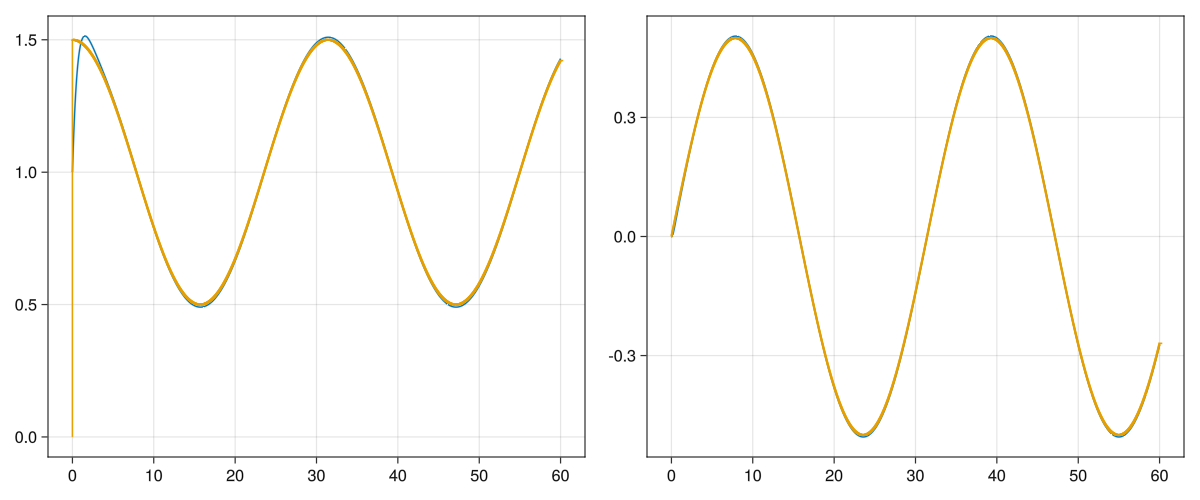

GLMakie.Screen(...)

In [565]:
fig = Figure(resolution = (1200, 500))

ax1 = Axis(fig[1, 1])
ax2 = Axis(fig[1, 2])

# position
lines!(ax1, sol.t, sol[plant.Y[2]])
lines!(ax1, sol.t, sol[controller.R[2]])

# attitude
lines!(ax2, sol.t, sol[plant.Y[1]])
lines!(ax2, sol.t, sol[controller.R[1]])


# lines!(ax, sol.t, sol[controller.u])

display(fig)